# Case Study 1 : Yelp Data Analysis

**Required Readings:** 
* [Yelp Dataset Challenge](https://www.yelp.com/dataset_challenge) 
* Please download the Yelp dataset from the above webpage.

**NOTE**
* Please don't forget to save the notebook frequently when working in Jupyter Notebook, otherwise the changes you made can be lost.


Here is an example of the data format. More details are included [here](https://www.yelp.com/dataset_challenge)

## Business Objects

Business objects contain basic information about local businesses. The fields are as follows:

```json
{
  'type': 'business',
  'business_id': (a unique identifier for this business),
  'name': (the full business name),
  'neighborhoods': (a list of neighborhood names, might be empty),
  'full_address': (localized address),
  'city': (city),
  'state': (state),
  'latitude': (latitude),
  'longitude': (longitude),
  'stars': (star rating, rounded to half-stars),
  'review_count': (review count),
  'photo_url': (photo url),
  'categories': [(localized category names)]
  'open': (is the business still open for business?),
  'schools': (nearby universities),
  'url': (yelp url)
}
```
## Checkin Objects
```json
{
    'type': 'checkin',
    'business_id': (encrypted business id),
    'checkin_info': {
        '0-0': (number of checkins from 00:00 to 01:00 on all Sundays),
        '1-0': (number of checkins from 01:00 to 02:00 on all Sundays),
        ...
        '14-4': (number of checkins from 14:00 to 15:00 on all Thursdays),
        ...
        '23-6': (number of checkins from 23:00 to 00:00 on all Saturdays)
    }, # if there was no checkin for a hour-day block it will not be in the dict
}
```

# Problem: pick a data science problem that you plan to solve using Yelp Data
* The problem should be important and interesting, which has a potential impact in some area.
* The problem should be solvable using yelp data and data science solutions.

Please briefly describe in the following cell: what problem are you trying to solve? why this problem is important and interesting?

Majority of people want to eat good food at an affordable price, but they don't know the right restaurants to go to. 

Similarly, restaurants with reasonable rates want to attarct customers.

The problem is important for students as most of them don't earn while studying. 

# Data Collection/Processing: 

In [4]:
import pandas as pd
import numpy as np
import re

business = pd.read_json("business.json",lines=True)
checkin = pd.read_json("checkin.json",lines=True)

# Data Exploration: Exploring the Yelp Dataset

**(1) Finding the most popular business categories:** 
* print the top 10 most popular business categories in the dataset and their counts (i.e., how many business objects in each category). Here we say a category is "popular" if there are many business objects in this category (such as 'restaurants').

In [2]:
s = business['categories']
category_list=[]
for i in (s):
    if i is not None:
        split_list =re.sub(r'\s', '', i).split(',')
        for j in split_list:
            category_list.append(str(j))
from collections import Counter
count = Counter(category_list)
count.most_common(10)

[('Restaurants', 59371),
 ('Shopping', 31878),
 ('Food', 29989),
 ('HomeServices', 19729),
 ('Beauty&Spas', 19370),
 ('Health&Medical', 17171),
 ('LocalServices', 13932),
 ('Automotive', 13203),
 ('Nightlife', 13095),
 ('Bars', 11341)]

** (2) Find the most popular business objects** 
* print the top 10 most popular business objects in the dataset and their counts (i.e., how many checkins in total for each business object).  Here we say a business object is "popular" if the business object attracts a large number of checkins from the users.

In [1]:
#We used the Checkin Dataset to print the top 10 most popular business objects
len_list = []
for i in checkin['date']:
    split_list = (re.sub(r'\s', '', i).split(','))
    len_list.append(len(split_list))
top_restaurants = [x for _,x in sorted(zip(len_list,checkin['business_id']),reverse=True)]
top_length = sorted(len_list,reverse=True)
top_restaurants[0:10]


['FaHADZARwnY4yvlvpnsfGA',
 'JmI9nslLD7KZqRr__Bg6NQ',
 'yQab5dxZzgBLTEHCw9V7_w',
 '5LNZ67Yw9RD6nf4_UhXOjw',
 'IZivKqtHyz4-ts8KsnvMrA',
 'SMPbvZLSMMb7KU76YNYMGg',
 'Wxxvi3LZbHNIDwJ-ZimtnA',
 'na4Th5DrNauOv-c43QQFvA',
 'VyjyHoBg3KC5BSFRlD0ZPQ',
 'El4FC8jcawUVgw_0EIcbaQ']

# The Solution: implement a data science solution to the problem you are trying to solve.

Briefly describe the idea of your solution to the problem in the following cell:

We have used NLP to perform Sentiment Analysis on the review Dataset to figure out the affordable restaurants in a particular City based on the word 'price' and wild card as a suffix or prefix. Ex: pricey,overpriced
We performed this on a couple of cities in Arizona State.

The next step was to build a recommendation system using Matrix Decomposition, using the User, Business and Review Dataset.

Shape of the matrix(R) is (user_id X business_id) and the rating as the values. 

If R[i][j] = 0, then it means that i user has not rated j restaurant.

Example : R[i,j]= 3.5 where, i=user_id, j=business_id

The final prediction matrix will have original ratings and the predicted rating.
This would be a ixj matrix with no null values. Null values will be replaced by the predicted ratings.

Thus we can suggest affordable restaurants to the users

Write codes to implement the solution in python:

In [ ]:
#code for Sentiment Analysis
import nltk
nltk.download('punkt')
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer 
sia=SentimentIntensityAnalyzer()

df=pd.read_csv("yelp_review.csv")
df['compound']=''

for column, value in df.items():
    if column=='text':
        for index in value.index: #value is a list of all reviews
            if re.search(r"\bprice",value[index],re.I) !=None:  #value[index] refers to each individual review
                t=nltk.sent_tokenize(value[index])  #breaks down each paragraph(i.e review) into sentences
                for a in t:
                    if re.search(r"\bprice",a,re.I) !=None: # search for keyword price in each sentence
                        sentiment_dict = sia.polarity_scores(a)             
                        df.at[index,'compound']=sentiment_dict['compound']

r=df[df['compound'] != ''] #drop all rows which have no compound value i.e no reviews with keyword price
rev_df=r.astype({'compound': 'float32'}) #convert compound column from object type to float
rev_df= rev_df.groupby(['text'],as_index=False)['compound'].mean()
review_df=pd.DataFrame(rev_df)

df.drop(axis=1,columns=['compound'],inplace=True)
df.drop_duplicates(subset='text',inplace=True)

finalReviewDF=df.merge(review_df,left_on='text',right_on='text')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Omkar\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
#code for Matrix Decomposition and building prediction matrix R
import pandas as pd
import numpy as np
import re


business = pd.read_json("business.json",lines=True)
AZ_business = business[(business["state"]=='AZ')]
AZ_open_business = AZ_business[(AZ_business["is_open"] == 1)]
AZ_open_restaurants = AZ_open_business[(business["city"]=='Carefree')]
AZ_open_restaurants = AZ_open_restaurants[AZ_business['categories'].str.contains("Restaurants", case=False)==True]

a=list(AZ_open_restaurants['business_id'])
df_2=finalReviewDF[finalReviewDF['business_id'].isin(a)]
userid = df_2.user_id.unique()

busid = df_2.business_id.unique()

A = np.zeros((len(userid),len(busid)))

df_mat = df_2.as_matrix()

for i in range(len(df_mat)):
    if df_mat[i][9]>=0.0:
        print(i)
        a = np.where(userid==(df_mat[i][1]))

        b = np.where(busid==(df_mat[i][2]))
        A[int(a[0])][int(b[0])] =df_mat[i][3]


def compute_L(R,U,V):

    L =np.zeros((R.shape[0],R.shape[1]))
    print('2')
    for i in range(R.shape[0]):
        
        for j in range(R.shape[1]):
            if R[i][j]!= 0:
                    
                    L[i,j]= R[i,j] - np.dot(U[i,:],V[:,j])
            else:
                    L[i][j] = 0    

    #########################################
    return L

#--------------------------
def compute_dU(L,U, V,mu=1.):
    dU= -2*np.matmul(L,np.transpose(V)) + 2*mu*U  
    print('3')
    #########################################
    return dU 

#--------------------------
def compute_dV(L,U, V, mu=1.):

    dV= -2*np.matmul(np.transpose(U),L) + 2*mu*V  

    print('4')
    #########################################
    return dV 

#--------------------------
def update_U(U, dU, beta=.001):
    U_new = U - beta*dU
    print('5')
    #########################################
    return U_new
#--------------------------
def update_V(V, dV, beta=.001):
    V_new = V - beta*dV
    print('6')
    #########################################
    return V_new
def matrix_decoposition(R, k=10, max_steps=1000000, beta=.01, mu=.01):
    n_movies, n_users = R.shape
    U = np.random.rand(n_movies, k)
    MM=0
    V = np.random.rand(k, n_users)
    print('7')
    for _ in range(max_steps): 
        MM = MM+1
        L = compute_L(R,U,V)

        dU= compute_dU(L,U,V,mu)    
        U_new = update_U(U,dU,beta)
        if np.allclose(U_new,U) == True:
            break
        U = U_new




        dV = compute_dV(L,U,V,mu)
        V_new = update_V(V,dV,beta)
        if np.allclose(V_new,V) == True:
            break
        V = V_new
        print(MM)
        #########################################
    return U, V

U_new,V_new = matrix_decoposition(A, k=25, max_steps=1000000, beta=.01, mu=.01)

final = np.matmul(U_new,V_new)

Mat=pd.DataFrame(final,columns=busid)

Mat['user_id']=userid

Prediction_Matrix=Mat.set_index('user_id').reset_index()

# Results: summarize and visualize the results discovered from the analysis

Please use figures, tables, or videos to communicate the results with the audience.


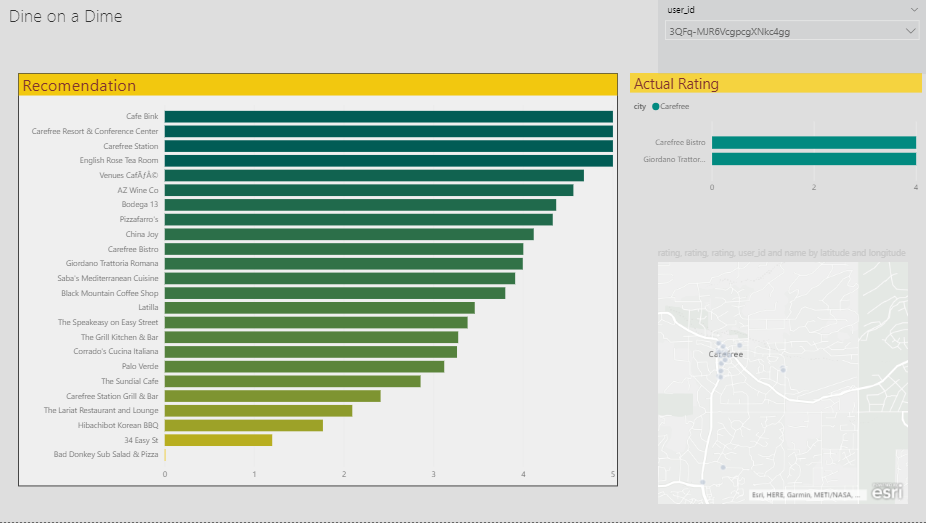
This Visual shows the predicted rating of all the cheap restaurants in Carefree AZ for a user ID.


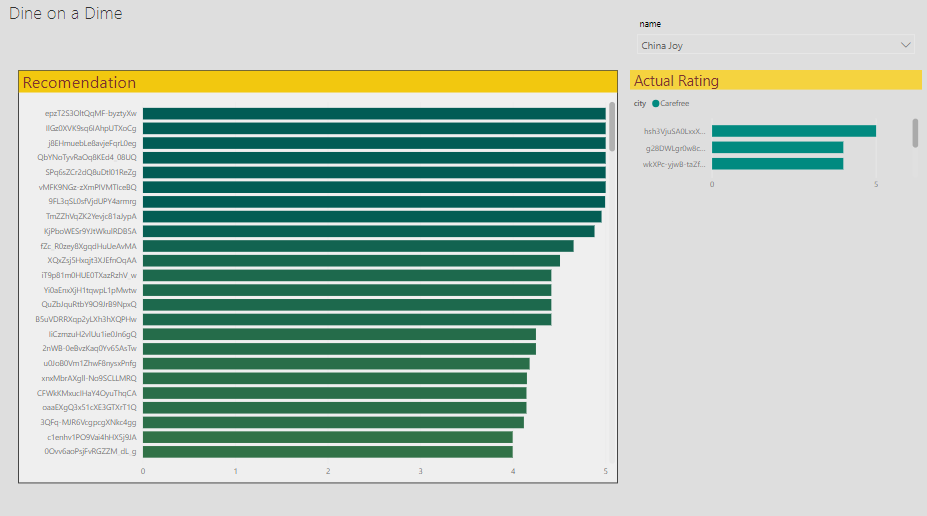
This Visual shows the predicted rating all the users are going to give a business.

*-----------------
# Done

All set! 

**What do you need to submit?**

* **Notebook File**: Save this Jupyter notebook, and find the notebook file in your folder (for example, "filename.ipynb"). This is the file you need to submit. Please make sure all the plotted tables and figures are in the notebook. If you used "jupyter notebook --pylab=inline" to open the notebook, all the figures and tables should have shown up in the notebook.

* **PPT Slides**: please prepare PPT slides (for 7 minutes' talk) to present about the case study . Each team present their case studies in class for 7 minutes.

Please compress all the files in a zipped file.


**How to submit:**

        Please submit through Canvas, in the Assignment "Case Study 1".
        
**Note: Each team only needs to submit one submission in Canvas**


# Peer-Review Grading Template:

**Total Points: (100 points)** Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.

Please add an "**X**" mark in front of your rating: 

For example:

*2: bad*
          
**X** *3: good*
    
*4: perfect*


    ---------------------------------
    The Problem: 
    ---------------------------------
    
    1. (10 points) how well did the team describe the problem they are trying to solve using the data? 
       0: not clear
       2: I can barely understand the problem
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
    
    2. (10 points) do you think the problem is important or has a potential impact?
        0: not important at all
        2: not sure if it is important
        4: seems important, but not clear
        6: interesting problem
        8: an important problem, which I want to know the answer myself
       10: very important, I would be happy invest money on a project like this.
    
    ----------------------------------
    Data Collection and Processing:
    ----------------------------------
    
    3. (10 points) Do you think the data collected/processed are relevant and sufficient for solving the above problem? 
       0: not clear
       2: I can barely understand what data they are trying to collect/process
       4: I can barely understand why the data is relevant to the problem
       6: the data are relevant to the problem, but better data can be collected
       8: the data collected are relevant and at a proper scale
      10: the data are properly collected and they are sufficient

    -----------------------------------
    Data Exploration:
    -----------------------------------
    4. How well did the team solve the following task:
    
    (1) Finding the most popular business categories (5 points):
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    (2) Find the most popular business objects (5 points)
       0: missing answer
       1: okay, but with major problems
       3: good, but with minor problems
       5: perfect
    
    -----------------------------------
    The Solution
    -----------------------------------
    5.  how well did the team describe the solution they used to solve the problem? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
       10: crystal clear
       
    6. how well is the solution in solving the problem? (10 points)
       0: not relevant
       2: barely relevant to the problem
       4: okay solution, but there is an easier solution.
       6: good, but can be improved
       8: very good, but solution is simple/old
       10: innovative and technically sound
       
    7. how well did the team implement the solution in python? (10 points)
       0: the code is not relevant to the solution proposed
       2: the code is barely understandable, but not relevant
       4: okay, the code is clear but incorrect
       6: good, the code is correct, but with major errors
       8: very good, the code is correct, but with minor errors
      10: perfect 
   
    -----------------------------------
    The Results
    -----------------------------------
     8.  How well did the team present the results they found in the data? (10 points)
       0: not clear
       2: I can barely understand
       4: okay, can be improved
       6: good, but can be improved
       8: very good
      10: crystal clear
       
     9.  How do you think of the results they found in the data?  (5 points)
       0: not clear
       1: likely to be wrong
       2: okay, maybe wrong
       3: good, but can be improved
       4: make sense, but not interesting
       5: make sense and very interesting
     
    -----------------------------------
    The Presentation
    -----------------------------------
    10. How all the different parts (data, problem, solution, result) fit together as a coherent story?  
       0: they are irrelevant
       1: I can barely understand how they are related to each other
       2: okay, the problem is good, but the solution doesn't match well, or the problem is not solvable.
       3: good, but the results don't make much sense in the context
       4: very good fit, but not exciting (the storyline can be improved/polished)
       5: a perfect story
      
    11. Did the presenter make good use of the 10 minutes for presentation?  
       0: the team didn't present
       1: bad, barely finished a small part of the talk
       2: okay, barely finished most parts of the talk.
       3: good, finished all parts of the talk, but some part is rushed
       4: very good, but the allocation of time on different parts can be improved.
       5: perfect timing and good use of time      

    12. How well do you think of the presentation (overall quality)?  
       0: the team didn't present
       1: bad
       2: okay
       3: good
       4: very good
       5: perfect


    -----------------------------------
    Overall: 
    -----------------------------------
    13. How many points out of the 100 do you give to this project in total?  Please don't worry about the absolute scores, we will rescale the final grading according to the performance of all teams in the class.
    Total score:
    
    14. What are the strengths of this project? Briefly, list up to 3 strengths.
       1: 
       2:
       3:
    
    15. What are the weaknesses of this project? Briefly, list up to 3 weaknesses.
       1:
       2:
       3:
    
    16. Detailed comments and suggestions. What suggestions do you have for this project to improve its quality further.
    
    
    

    ---------------------------------
    Your Vote: 
    ---------------------------------
    [Overall Quality] Between the two submissions that you are reviewing, which team would you vote for a better score?  (5 bonus points)
        0: I vote the other team is better than this team
        5: I vote this team is better than the other team 
        


